### Importing packages

In [1]:
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import itertools
import re
from pulp import *

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
compatibility = pd.read_excel("donor_recepient_information.xlsx", sheet_name="pre_surgical_compatibility")
compatibility.set_index(["Donor"], inplace=True)


time_to_reach = pd.read_excel("donor_recepient_information.xlsx", sheet_name="TimeToReach")
time_to_reach.set_index(["Donor"], inplace=True)


survival = pd.read_excel("donor_recepient_information.xlsx", sheet_name="post_surgical_survival_rate")
survival.set_index(["Donor"], inplace=True)


# Display snipped data
display_side_by_side(dfs=[compatibility.iloc[0:5, 0:5],
                          time_to_reach.iloc[0:5, 0:5],
                          survival.iloc[0:5, 0:5]],
                     captions=["Pre-Surgical donor compatibility with recipient",
                               "Time to reach from donor to recipient (in hours)",
                               "Post-Surgical Survival Rate"])

,Recipient_1,Recipient_2,Recipient_3,Recipient_4,Recipient_5
Donor,,,,,
Donor_1,0.232000,0.810000,0.288000,0.482000,0.941000
Donor_2,0.865000,0.804000,0.371000,0.670000,0.518000
Donor_3,0.460000,0.672000,0.106000,0.501000,0.932000
Donor_4,0.924000,0.250000,0.703000,0.598000,0.715000
Donor_5,0.954000,0.932000,0.224000,0.849000,0.531000
,Recipient_1,Recipient_2,Recipient_3,Recipient_4,Recipient_5
Donor,,,,,
Donor_1,1.630000,5.770000,1.780000,2.320000,2.060000
Donor_2,5.340000,2.620000,4.420000,4.170000,5.350000


### Decision variables

In [3]:
donor_list = compatibility.index.to_list()

recipient_list = compatibility.columns.to_list()


var_dict = LpVariable.dicts(name = "Match Found",
                            indexs = [(d, r) for d in donor_list for r in recipient_list], 
                            cat = "Binary")

### Define the objective functions

In [4]:
# Objective 1: Maximize donor compatibility
objective_1 = lpSum([compatibility.loc[d, r]*var_dict[(d, r)] for d in donor_list for r in recipient_list])

# Objective 2: Minimize time to reach the nearest donor
objective_2 = lpSum([time_to_reach.loc[d, r]*var_dict[(d, r)] for d in donor_list for r in recipient_list])

# Objective 3: Maximize post surgery survival probability
objective_3 = lpSum([survival.loc[d, r]*var_dict[(d, r)] for d in donor_list for r in recipient_list])

### Iterating over multiple combination of weights for each objective

In [5]:
solutions = []

for num in tqdm(range(1000)):
    weights = np.array([random.random(), random.random(), random.random()])

    # Ensuring sum of all weights adds up to 1
    weights = weights/sum(weights)

    # Define the maximization LPP
    model = LpProblem("Best Match", LpMaximize)

    # Define single objective
    model += (weights[0] * objective_1) + (weights[1] * -objective_2) + (weights[2] * objective_3)

    # LP constraints
    #----Constraint_1 -> A donor can donate to only one recipient
    for d in donor_list:
        model += lpSum([var_dict[(d, r)] for r in recipient_list]) == 1

    #----Constraint_2 -> A recipient can recieve from only 1 donor
    for r in recipient_list:
        model += lpSum([var_dict[(d, r)] for d in donor_list]) == 1

    # Solving the LP
    model.solve()

    # Saving results
    solutions.append([objective_1.value(), 
                      objective_2.value(),
                      objective_3.value(), 
                      value(model.objective),
                      [(v.name,v.varValue) for v in model.variables() if v.varValue!=0]])


# Save optimized results as a dataframe
df_optimal = pd.DataFrame(solutions, columns=["Objective_1", 
                                              "Objective_2",
                                              "Objective_3",
                                              "Single_Objective",
                                              "Optimal_Solution"])

df_optimal.sort_values(by=["Single_Objective"], ascending=False).head()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.04it/s]


,Objective_1,Objective_2,Objective_3,Single_Objective,Optimal_Solution
647,18.268,63.78,14.0668,17.663307,"[(Match_Found_('Donor_1',_'Recipient_19'), 1.0..."
83,15.027,61.23,18.4842,17.534303,"[(Match_Found_('Donor_1',_'Recipient_11'), 1.0..."
70,17.995,56.90,15.6996,17.318118,"[(Match_Found_('Donor_1',_'Recipient_19'), 1.0..."
283,14.772,49.82,18.4499,17.290285,"[(Match_Found_('Donor_1',_'Recipient_11'), 1.0..."
981,17.129,71.89,17.3866,17.181734,"[(Match_Found_('Donor_1',_'Recipient_19'), 1.0..."


### Plotting the Pareto optimal frontier in 3-Dimensions

<IPython.core.display.Javascript object>


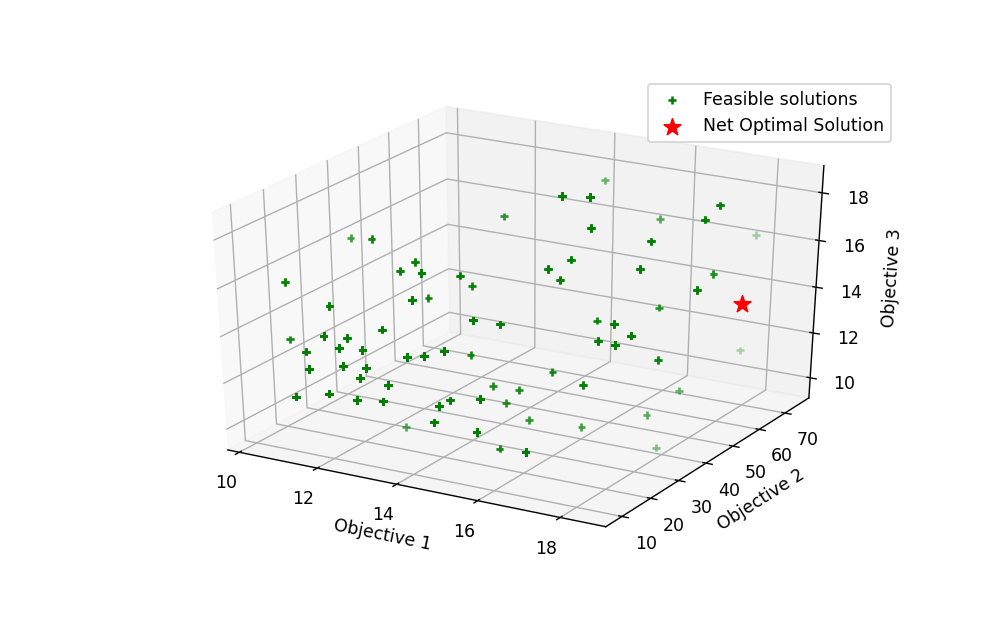

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


%matplotlib notebook
plt.rcParams["figure.figsize"] = (8, 5)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_optimal[df_optimal["Single_Objective"]!=max(df_optimal["Single_Objective"])]["Objective_1"], 
           df_optimal[df_optimal["Single_Objective"]!=max(df_optimal["Single_Objective"])]["Objective_2"],
           df_optimal[df_optimal["Single_Objective"]!=max(df_optimal["Single_Objective"])]["Objective_3"], 
           c='green',
           marker='+',
           label = "Feasible solutions")


ax.scatter(df_optimal[df_optimal["Single_Objective"]==max(df_optimal["Single_Objective"])]["Objective_1"], 
           df_optimal[df_optimal["Single_Objective"]==max(df_optimal["Single_Objective"])]["Objective_2"],
           df_optimal[df_optimal["Single_Objective"]==max(df_optimal["Single_Objective"])]["Objective_3"], 
           c='red',
           s=100,
           marker='*', 
           label = "Net Optimal Solution")

ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')

plt.legend()

plt.show()

### Finding the best case for donor-recipient pair

In [7]:
best_pair = df_optimal[df_optimal["Single_Objective"]==max(df_optimal["Single_Objective"])]

status = pd.DataFrame(list(best_pair["Optimal_Solution"])[0], columns = ["Decisions","Compatibility"])

status

,Decisions,Compatibility
0,"Match_Found_('Donor_1',_'Recipient_19')",1.0
1,"Match_Found_('Donor_10',_'Recipient_2')",1.0
2,"Match_Found_('Donor_11',_'Recipient_11')",1.0
3,"Match_Found_('Donor_12',_'Recipient_13')",1.0
4,"Match_Found_('Donor_13',_'Recipient_16')",1.0
5,"Match_Found_('Donor_14',_'Recipient_18')",1.0
6,"Match_Found_('Donor_15',_'Recipient_14')",1.0
7,"Match_Found_('Donor_16',_'Recipient_15')",1.0
8,"Match_Found_('Donor_17',_'Recipient_17')",1.0
9,"Match_Found_('Donor_18',_'Recipient_4')",1.0
